# Nasal Segmentation with U-Net

This notebook processes NRRD files using the trained U-Net model for nasal cavity segmentation.

In [2]:
import torch
import torch.nn as nn
import nrrd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from PIL import Image

## 1. Device Configuration

In [3]:
# 检查GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

使用设备: cpu


## 2. U-Net Model Definition

In [4]:
# U-Net Model Architecture (same as training)
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        
        self.up1 = Up(256 + 128, 128)
        self.up2 = Up(128 + 64, 64)
        self.up3 = Up(64 + 32, 32)
        
        self.outc = nn.Conv2d(32, n_classes, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        
        return self.outc(x)

## 3. Load Trained Model

In [5]:
# Load best U-Net model
model = UNet(n_channels=3, n_classes=3).to(device)
checkpoint = torch.load('./checkpoints/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"模型加载成功 (验证损失: {checkpoint['val_loss']:.6f})")

模型加载成功 (验证损失: 0.002749)


## 4. Select Random NRRD Files

In [24]:
# Select 3 random NRRD files from NasalSeg/images
nrrd_dir = Path('./NasalSeg/images')
nrrd_files = list(nrrd_dir.glob('*.nrrd'))
selected_files = random.sample(nrrd_files, 3)

print("选中的文件:")
for f in selected_files:
    print(f"  - {f.name}")

# show the dimension of pixels the image
for file in selected_files:
    data, header = nrrd.read(file)
    print(f"{file.name} 像素维度: {data.shape}")

选中的文件:
  - P059_img.nrrd
  - P085_img.nrrd
  - P130_img.nrrd
P059_img.nrrd 像素维度: (148, 187, 53)
P085_img.nrrd 像素维度: (159, 176, 45)
P130_img.nrrd 像素维度: (137, 183, 47)


## 5. Processing Functions

Functions to:
1. Extract center 64×64 from NRRD slices
2. Normalize and convert to RGB
3. Resize to 256×256
4. Process with U-Net model

In [7]:
def process_nrrd_slice(slice_data, target_size=(64, 64)):
    """
    处理NRRD切片:
    1. 如果尺寸不是64×64,提取中心64×64区域
    2. 归一化到[0, 1]
    3. 转换为RGB (复制到3个通道)
    """
    h, w = slice_data.shape
    
    # Extract center 64x64 if dimensions don't match
    if h != target_size[0] or w != target_size[1]:
        center_h, center_w = h // 2, w // 2
        half_size = target_size[0] // 2
        slice_data = slice_data[
            center_h - half_size:center_h + half_size,
            center_w - half_size:center_w + half_size
        ]
    
    # Normalize to [0, 1]
    slice_min, slice_max = slice_data.min(), slice_data.max()
    if slice_max > slice_min:
        slice_data = (slice_data - slice_min) / (slice_max - slice_min)
    else:
        slice_data = np.zeros_like(slice_data)
    
    # Convert to RGB (3 channels)
    rgb_slice = np.stack([slice_data] * 3, axis=-1)
    
    return rgb_slice

def resize_to_256(img_array):
    """将64×64图像调整为256×256"""
    img_pil = Image.fromarray((img_array * 255).astype(np.uint8))
    img_resized = img_pil.resize((256, 256), Image.BICUBIC)
    return np.array(img_resized) / 255.0

def process_with_model(img_array, model, device):
    """使用U-Net模型处理图像"""
    # Convert to tensor
    img_tensor = torch.from_numpy(img_array.transpose(2, 0, 1)).float()
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Inference
    with torch.no_grad():
        output = model(img_tensor)
    
    # Convert back to numpy
    output_np = output.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    output_np = np.clip(output_np, 0, 1)
    
    return output_np

## 6. Process All Selected Files

Process each NRRD file through the pipeline:
- Load NRRD file
- Select middle slice
- Extract center 64×64
- Resize to 256×256
- Run through U-Net model

In [8]:
# Process all selected files
results = []

for nrrd_file in selected_files:
    print(f"\n处理文件: {nrrd_file.name}")
    
    # Read NRRD file
    data, header = nrrd.read(str(nrrd_file))
    print(f"  原始形状: {data.shape}")
    
    # Select middle slice (assuming 3D volume)
    if data.ndim == 3:
        middle_idx = data.shape[0] // 2
        slice_data = data[middle_idx, :, :]
        print(f"  选择中间切片 (索引: {middle_idx})")
    else:
        slice_data = data
    
    print(f"  切片形状: {slice_data.shape}")
    
    # Process slice
    processed_64 = process_nrrd_slice(slice_data, target_size=(64, 64))
    print(f"  处理后64×64: {processed_64.shape}")
    
    # Resize to 256×256
    resized_256 = resize_to_256(processed_64)
    print(f"  调整为256×256: {resized_256.shape}")
    
    # Run through model
    output = process_with_model(resized_256, model, device)
    print(f"  模型输出: {output.shape}")
    
    results.append({
        'filename': nrrd_file.name,
        'original': slice_data,
        'processed_64': processed_64,
        'input_256': resized_256,
        'output_256': output
    })

print("\n所有文件处理完成!")


处理文件: P014_img.nrrd
  原始形状: (163, 201, 49)
  选择中间切片 (索引: 81)
  切片形状: (201, 49)
  处理后64×64: (64, 8, 3)
  调整为256×256: (256, 256, 3)
  模型输出: (256, 256, 3)

处理文件: P109_img.nrrd
  原始形状: (125, 166, 50)
  选择中间切片 (索引: 62)
  切片形状: (166, 50)
  处理后64×64: (64, 7, 3)
  调整为256×256: (256, 256, 3)
  模型输出: (256, 256, 3)

处理文件: P028_img.nrrd
  原始形状: (184, 201, 59)
  选择中间切片 (索引: 92)
  切片形状: (201, 59)
  处理后64×64: (64, 3, 3)
  调整为256×256: (256, 256, 3)
  模型输出: (256, 256, 3)

所有文件处理完成!


## 7. Visualize Results

Display side-by-side comparisons:
- Column 1: Original NRRD slice
- Column 2: Center 64×64 (Normalized RGB)
- Column 3: Input 256×256 (Bicubic upsampled)
- Column 4: U-Net Output 256×256

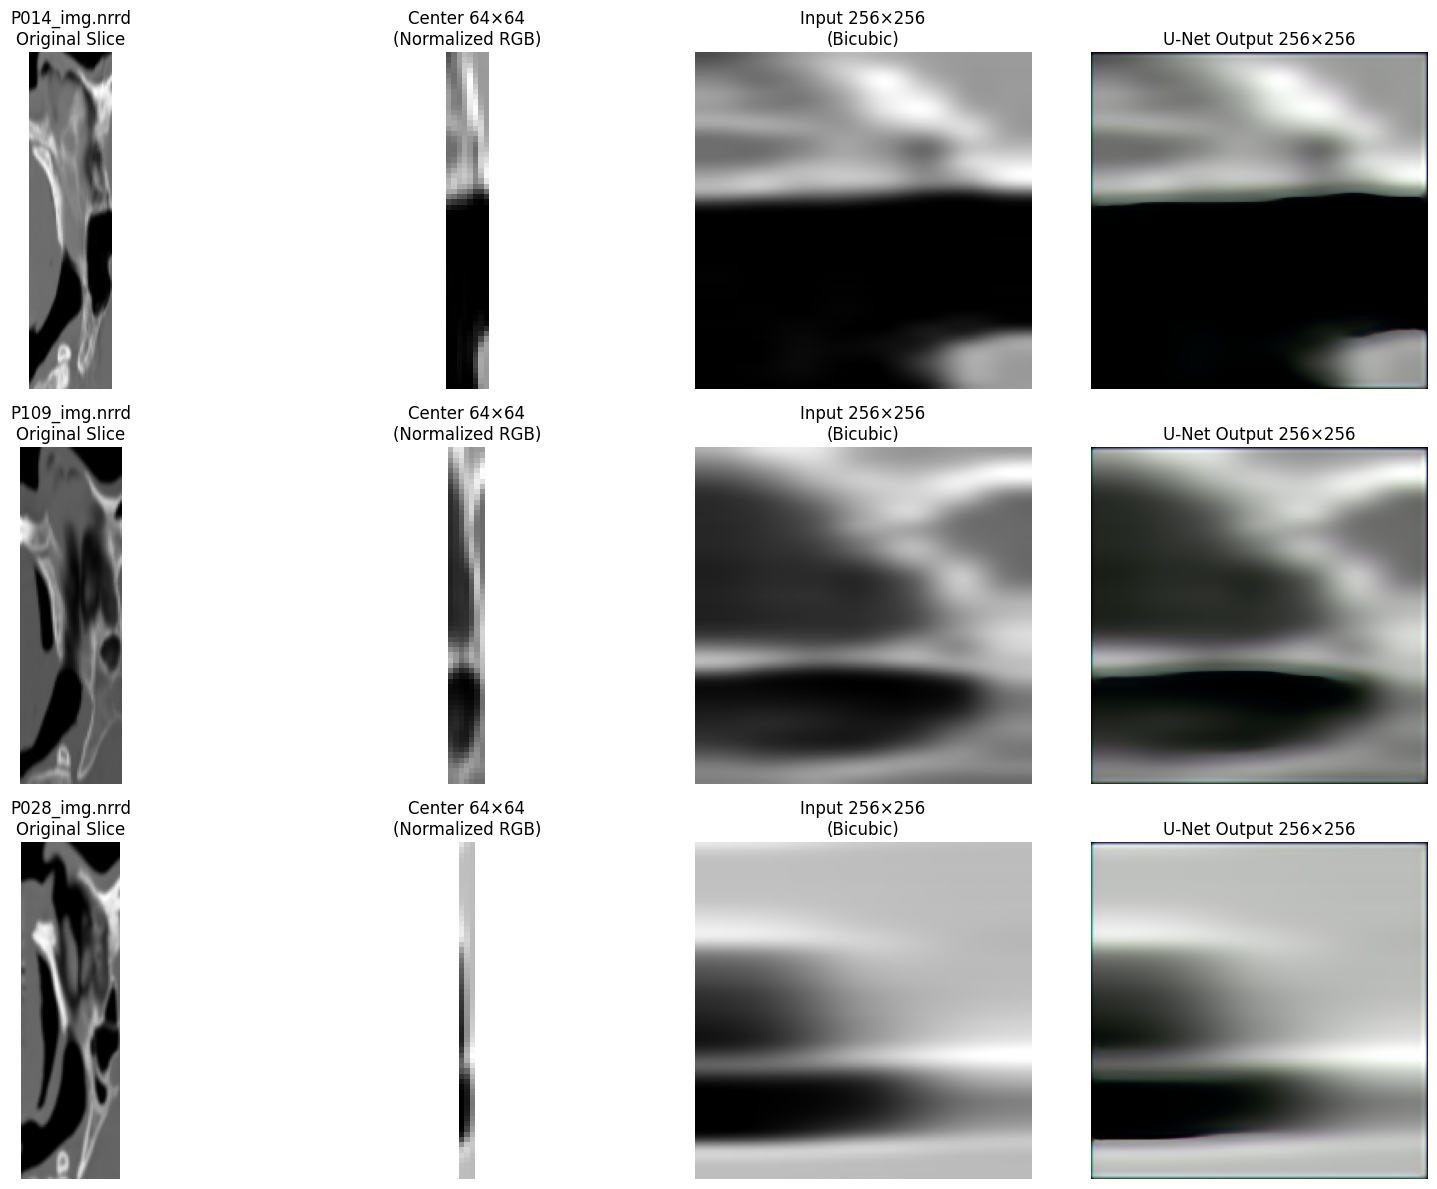

结果已保存: nasal_seg_results.png


In [9]:
# Visualize results
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, result in enumerate(results):
    # Original slice
    axes[i, 0].imshow(result['original'], cmap='gray')
    axes[i, 0].set_title(f"{result['filename']}\nOriginal Slice")
    axes[i, 0].axis('off')
    
    # Processed 64×64
    axes[i, 1].imshow(result['processed_64'])
    axes[i, 1].set_title("Center 64×64\n(Normalized RGB)")
    axes[i, 1].axis('off')
    
    # Input 256×256
    axes[i, 2].imshow(result['input_256'])
    axes[i, 2].set_title("Input 256×256\n(Bicubic)")
    axes[i, 2].axis('off')
    
    # Model output 256×256
    axes[i, 3].imshow(result['output_256'])
    axes[i, 3].set_title("U-Net Output 256×256")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig('nasal_seg_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("结果已保存: nasal_seg_results.png")